In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 
from collections import defaultdict
from scipy.stats import pearsonr

# Tweets data preparation

In [2]:
tweets = pd.read_csv('../tweets.csv')

In [3]:
tweets['id'] = pd.to_numeric(tweets['id'], errors='coerce')
tweets['user_id'] = pd.to_numeric(tweets['user_id'], errors='coerce')
tweets['retweet_count'] = pd.to_numeric(tweets['retweet_count'], errors='coerce')
tweets['reply_count'] = pd.to_numeric(tweets['reply_count'], errors='coerce')
tweets['favorite_count'] = pd.to_numeric(tweets['favorite_count'], errors='coerce')
tweets['num_hashtags'] = pd.to_numeric(tweets['num_hashtags'], errors='coerce')
tweets['num_mentions'] = pd.to_numeric(tweets['num_mentions'], errors='coerce')
tweets['num_urls'] = pd.to_numeric(tweets['num_urls'], errors='coerce')
tweets['created_at'] = pd.to_datetime(tweets['created_at'], errors='coerce')

In [4]:
tweets['reply_count'].describe()

count    12855192.0
mean            inf
std             NaN
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             inf
Name: reply_count, dtype: float64

In [5]:
tweets['reply_count'].unique()

array([0.0000000e+000,            nan, 1.0000000e+000, 8.0000000e+009,
       2.0000000e+000, 8.0000000e+000, 1.8000000e+001, 4.0000000e+000,
       1.7000000e+001, 1.0700000e+002, 1.6467330e+006, 5.2000000e+001,
       8.5800000e+002, 3.0000000e+000, 3.3000000e+001, 5.0000000e+000,
       6.0000000e+000, 5.3000000e+001, 1.3300000e+002, 1.6300000e+002,
       1.4000000e+001, 1.6800000e+002, 7.0000000e+000, 9.1600000e+002,
       5.0000000e+001, 5.5000000e+001, 7.3380000e+003, 2.5400000e+002,
       1.1000000e+001, 2.3500000e+002, 2.6000000e+001, 8.9500000e+002,
       7.3800000e+002, 3.6000000e+001, 1.0000000e+001, 9.0000000e+000,
       4.7000000e+001, 7.2500000e+002, 5.9000000e+001, 9.6000000e+002,
       1.2700000e+002, 9.1700000e+002, 1.6000000e+001, 1.5000000e+001,
       3.1000000e+001, 8.9400000e+002, 6.5700000e+006, 2.8000000e+001,
       4.1700000e+002, 1.2000000e+001, 3.4000000e+001, 2.2000000e+001,
       2.4000000e+001, 7.6000000e+001, 3.9300000e+002, 2.8900000e+002,
      

In [6]:
tweets[tweets['reply_count'] > tweets['reply_count'].quantile(.999)]['reply_count'].unique()

array([8.0000000e+009, 2.0000000e+000, 8.0000000e+000, 1.8000000e+001,
       4.0000000e+000, 1.7000000e+001, 1.0700000e+002, 1.6467330e+006,
       5.2000000e+001, 8.5800000e+002, 3.0000000e+000, 3.3000000e+001,
       5.0000000e+000, 6.0000000e+000, 5.3000000e+001, 1.3300000e+002,
       1.6300000e+002, 1.4000000e+001, 1.6800000e+002, 7.0000000e+000,
       9.1600000e+002, 5.0000000e+001, 5.5000000e+001, 7.3380000e+003,
       2.5400000e+002, 1.1000000e+001, 2.3500000e+002, 2.6000000e+001,
       8.9500000e+002, 7.3800000e+002, 3.6000000e+001, 1.0000000e+001,
       9.0000000e+000, 4.7000000e+001, 7.2500000e+002, 5.9000000e+001,
       9.6000000e+002, 1.2700000e+002, 9.1700000e+002, 1.6000000e+001,
       1.5000000e+001, 3.1000000e+001, 8.9400000e+002, 6.5700000e+006,
       2.8000000e+001, 4.1700000e+002, 1.2000000e+001, 3.4000000e+001,
       2.2000000e+001, 2.4000000e+001, 7.6000000e+001, 3.9300000e+002,
       2.8900000e+002, 7.0000000e+001, 1.6610000e+003, 2.3000000e+001,
      

## Eliminazione dei valori negativi

In [7]:
tweets['retweet_count'] = tweets['retweet_count'].abs()
tweets['reply_count'] = tweets['reply_count'].abs()
tweets['favorite_count'] = tweets['favorite_count'].abs()
tweets['num_hashtags'] = tweets['num_hashtags'].abs()
tweets['num_mentions'] = tweets['num_mentions'].abs()
tweets['num_urls'] = tweets['num_urls'].abs()

## Eliminazione dei valori inf

In [8]:
tweets.replace(math.inf, math.nan, inplace=True)
tweets.replace('inf', math.nan, inplace=True)

## Manage duplicates:

### Dropping duplicates:

In [9]:
tweets.drop_duplicates(inplace=True)

### Find and replace duplicated 'id'

In [10]:
mask = tweets.duplicated('id', keep=False)
tweets.loc[mask, 'id'] = -1

## Replacing NaN values:

### Replace NaN values in 'id'

Replace nan values with a value (-1) that indicates that this information is missing

In [11]:
tweets.loc[tweets['id'].isna(), 'id'] = -1

### Replacing NaN values in 'num_hashtags', 'num_urls' and 'num_mentions' by infer from the tweet's text

In [12]:
tweets['infer_hashtags'] = tweets.text.str.count('#')
tweets['infer_mentions'] = tweets.text.str.count('@')
tweets['infer_urls'] = tweets.text.str.count('http://')

tweets['num_hashtags'] = tweets['num_hashtags'].fillna(tweets['infer_hashtags'])
tweets['num_mentions'] = tweets['num_mentions'].fillna(tweets['infer_mentions'])
tweets['num_urls'] = tweets['num_urls'].fillna(tweets['infer_urls'])

tweets.drop(columns=['infer_hashtags', 'infer_mentions', 'infer_urls'], inplace=True)

### Replacing NaN values with the median of the user

In [13]:
t = tweets
user_median = t.groupby('user_id', as_index=False).median()
user_median.rename(columns={
    'retweet_count' : 'retweet_median',
    'reply_count' : 'reply_median',
    'favorite_count' : 'favorite_median',
    'num_hashtags' : 'hashtags_median',
    'num_urls' : 'urls_median',
    'num_mentions' : 'mentions_median'
}, inplace=True)
user_median.drop(columns=['id'], inplace=True)
tweets = t.merge(user_median, on='user_id')

#sostituzione valori
tweets['retweet_count'] = tweets['retweet_count'].fillna(tweets['retweet_median'])
tweets['reply_count'] = tweets['reply_count'].fillna(tweets['reply_median'])
tweets['favorite_count'] = tweets['favorite_count'].fillna(tweets['favorite_median'])
tweets['num_hashtags'] = tweets['num_hashtags'].fillna(tweets['hashtags_median'])
tweets['num_mentions'] = tweets['num_mentions'].fillna(tweets['mentions_median'])
tweets['num_urls'] = tweets['num_urls'].fillna(tweets['urls_median'])

tweets.drop(columns=['retweet_median', 'reply_median', 'favorite_median', 'hashtags_median', 'mentions_median', 'urls_median'], \
            inplace=True)


### Fill the remained NaN values with the median of the attribute

In [14]:
tweets['retweet_count'] = tweets['retweet_count'].fillna(tweets['retweet_count'].median())
tweets['reply_count'] = tweets['reply_count'].fillna(tweets['reply_count'].median())
tweets['favorite_count'] = tweets['favorite_count'].fillna(tweets['favorite_count'].median())
tweets['num_hashtags'] = tweets['num_hashtags'].fillna(tweets['num_hashtags'].median())
tweets['num_mentions'] = tweets['num_mentions'].fillna(tweets['num_mentions'].median())
tweets['num_urls'] = tweets['num_urls'].fillna(tweets['num_urls'].median())

## Replacing invalid 'created_at' with symbolic date (01/01/2000)

In [15]:
tweets.loc[(tweets.created_at < datetime.strptime("2006-07-15 00:00:00", "%Y-%m-%d %H:%M:%S")) | \
    (tweets.created_at > datetime.now()),'created_at'] = datetime.strptime("2000-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")

In [16]:
backup = tweets

In [17]:
tweets = backup

## Manage outliers

In [18]:
tweets.loc[tweets['retweet_count'] > tweets['retweet_count'].quantile(.95), 'retweet_count'] = tweets['retweet_count'].median()
tweets.loc[tweets['reply_count'] > tweets['reply_count'].quantile(.9999), 'reply_count'] = tweets['reply_count'].median()
tweets.loc[tweets['favorite_count'] > tweets['favorite_count'].quantile(.995), 'favorite_count'] = tweets['favorite_count'].median()
tweets.loc[tweets['num_hashtags'] > tweets['num_hashtags'].quantile(.999), 'num_hashtags'] = tweets['num_hashtags'].median()
tweets.loc[tweets['num_mentions'] > tweets['num_mentions'].quantile(.999), 'num_mentions'] = tweets['num_mentions'].median()
tweets.loc[tweets['num_urls'] > tweets['num_urls'].quantile(.9999), 'num_urls'] = tweets['num_urls'].median()


<AxesSubplot:>

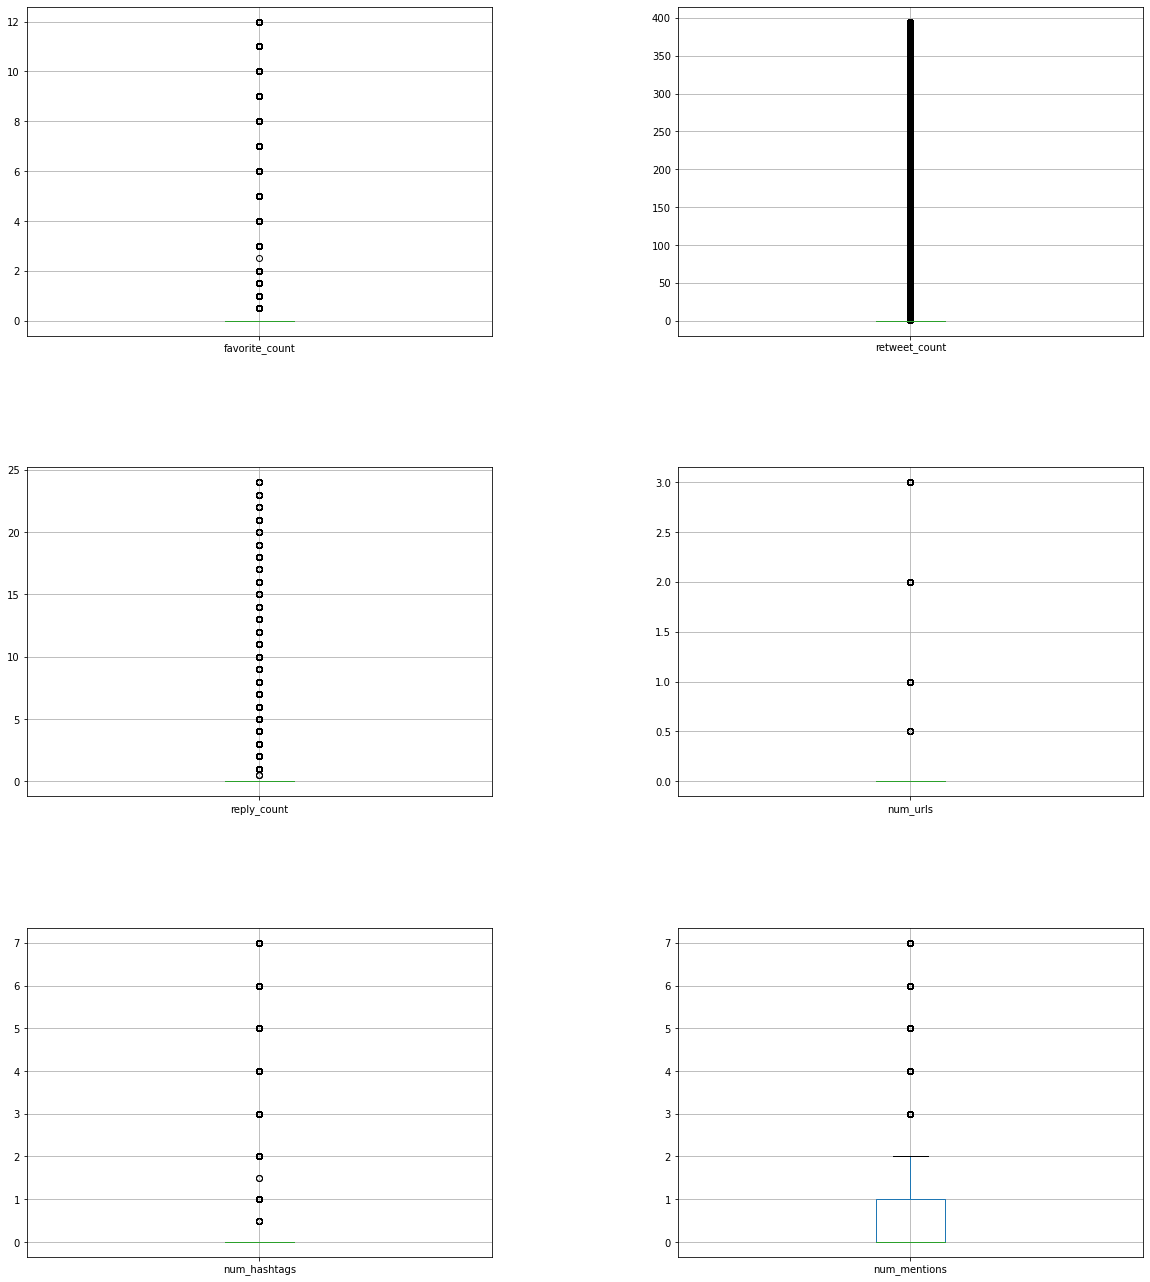

In [19]:
fig = plt.figure(figsize=(20, 23))
fig_dims = (3, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

######
plt.subplot2grid(fig_dims, (0,0))
tweets.boxplot(column=['favorite_count'])

######
plt.subplot2grid(fig_dims, (0,1))
tweets.boxplot(column=['retweet_count'])

######
plt.subplot2grid(fig_dims, (1,0))
tweets.boxplot(column=['reply_count'])

######
plt.subplot2grid(fig_dims, (1,1))
tweets.boxplot(column=['num_urls'])

######
plt.subplot2grid(fig_dims, (2,0))
tweets.boxplot(column=['num_hashtags'])

######
plt.subplot2grid(fig_dims, (2,1))
tweets.boxplot(column=['num_mentions'])

## Tweets indicators

### Number of special character:

In [20]:
special = '[(|!£$%&/=?^@#§,.;:-_<>ç@)]' # Define special characters
tweets['special'] = tweets['text'].str.count(special) # Count them
tweets['special'] = tweets['special'].fillna(0)
tweets['special'] = tweets['special'].astype(int)

### Text lenght:

In [21]:
tweets['text_lenght'] = tweets['text'].str.len()
tweets['text_lenght'] = tweets['text_lenght'].fillna(0)
tweets['text_lenght'] = tweets['text_lenght'].astype(int)

In [22]:
tweets['reply_count'].describe()

count    1.127870e+07
mean     2.889384e-03
std      1.395678e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.400000e+01
Name: reply_count, dtype: float64

## Write a new file '.csv' with all the modify done

In [23]:
tweets.to_csv('../new_tweets.csv')

# User data Preparation

This part use the previous modify done to the tweets dataframe.

In [24]:
users = pd.read_csv('../users.csv')
#tweets = pd.read_csv('new_tweets.csv', lineterminator='\n', index_col=0)

In [25]:
users.info()
users.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11508 non-null  int64  
 1   name            11507 non-null  object 
 2   lang            11508 non-null  object 
 3   bot             11508 non-null  int64  
 4   created_at      11508 non-null  object 
 5   statuses_count  11109 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 539.6+ KB


id                  int64
name               object
lang               object
bot                 int64
created_at         object
statuses_count    float64
dtype: object

## Column type conversion

In [26]:
users['id'] = pd.to_numeric(users['id'], errors='coerce')
users['statuses_count'] = pd.to_numeric(users['statuses_count'], errors='coerce')
users['created_at'] = pd.to_datetime(users['created_at'], errors='coerce')

## Elimination of negative values

In [27]:

users['statuses_count'] = users['statuses_count'].abs()

## Lang Correction

In [28]:
users['lang'] = users['lang'].str.lower()
users.rename(columns={
    'id' : 'user_id',
    'created_at' : 'subscribing_date'
}, inplace=True)
nal = users[(users['lang'] == 'select language...') | (users['lang'] == 'xx-lc')]

text_nal = tweets.merge(nal, on='user_id')
text_nal

/Users/Koto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1204: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text,special,text_lenght,name,lang,bot,subscribing_date,statuses_count
0,4.912745e+17,2.955215e+07,0.0,0.0,0.0,0.0,0.0,0.0,2019-07-23 17:32:30,"Spent the majority of my day drawing around, c...",10,111,Chloe,xx-lc,0,2014-04-09 21:36:02,15398.0
1,4.886930e+17,2.955215e+07,0.0,0.0,0.0,0.0,0.0,0.0,2019-07-16 14:34:25,We all love dem cuddles. http://t.co/fPrcnUfacS,10,47,Chloe,xx-lc,0,2014-04-09 21:36:02,15398.0
2,4.854109e+17,2.955215e+07,0.0,0.0,0.0,0.0,0.0,0.0,2019-07-07 13:12:33,Dog sitting until 8 tonight. Again..,5,36,Chloe,xx-lc,0,2014-04-09 21:36:02,15398.0
3,1.683542e+15,2.955215e+07,0.0,0.0,0.0,0.0,0.0,0.0,2019-07-16 20:58:50,NaN,0,0,Chloe,xx-lc,0,2014-04-09 21:36:02,15398.0
4,7.055459e+09,2.955215e+07,0.0,0.0,0.0,0.0,0.0,0.0,2020-02-27 20:17:18,The chocolate is soooooooooooo amazing.,2,39,Chloe,xx-lc,0,2014-04-09 21:36:02,15398.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,5.910286e+17,2.956614e+09,61.0,0.0,0.0,0.0,1.0,1.0,2020-04-23 23:59:43,RT @LivvyAllison: If you are reading the front...,20,120,Leanne Arker,select language...,0,2020-01-05 00:09:59,57.0
2192,4.789901e+10,2.956614e+09,3.0,0.0,0.0,2.0,0.0,2.0,2020-03-19 10:54:49,RT @sophieraworth: Last night over Sweden... R...,30,137,Leanne Arker,select language...,0,2020-01-05 00:09:59,57.0
2193,5.939970e+17,2.956614e+09,0.0,0.0,0.0,0.0,1.0,0.0,2020-05-02 04:35:05,I think even super heroes should rest at weeke...,12,75,Leanne Arker,select language...,0,2020-01-05 00:09:59,57.0
2194,7.268000e+16,2.956614e+09,3.0,0.0,1.0,0.0,0.0,3.0,2020-05-01 19:38:48,@annabf @CampbellLiveNZ @UniteUnion well done,9,45,Leanne Arker,select language...,0,2020-01-05 00:09:59,57.0


In [29]:
text_nal[text_nal['name'] == 'Leanne Arker'].head(3)

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text,special,text_lenght,name,lang,bot,subscribing_date,statuses_count
2130,5.866970e+17,2.956614e+09,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12 01:07:12,@bernardchickey I've heard of something called...,7,137,Leanne Arker,select language...,0,2020-01-05 00:09:59,57.0
2131,5.601363e+17,2.956614e+09,0.0,0.0,0.0,0.0,0.0,2.0,2020-01-29 18:04:45,RT @stephenfry: If physical diseases were trea...,16,110,Leanne Arker,select language...,0,2020-01-05 00:09:59,57.0
2132,5.751565e+17,2.956614e+09,0.0,0.0,0.0,0.0,0.0,1.0,2020-03-11 04:49:27,@Hilary_Barry Gives new meaning to the term sl...,5,62,Leanne Arker,select language...,0,2020-01-05 00:09:59,57.0


##### Users without a language are en

In [30]:
users['lang'].replace('select language...', 'en', inplace=True)
users['lang'].replace('xx-lc', 'en', inplace=True)

## Calculate for each user how many tweets we have in tweets.csv

In [31]:

users = users.merge(tweets[['user_id', 'id']].groupby('user_id', as_index=False).count(), on='user_id')
users = users.rename(columns={'id' : 'count'})
users.head(3)

/Users/Koto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1214: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,user_id,name,lang,bot,subscribing_date,statuses_count,count
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,132
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54.0,122
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3.0,4


In [32]:
users.loc[users['statuses_count'] < users['count'], 'statuses_count'] = users['count'] 

## Summing parameters in users (likes received, retweet and reply received)

In [33]:
new_tweets = tweets.filter(['user_id', 'retweet_count', 'reply_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions'], axis=1)
new_users = users.merge(new_tweets.groupby('user_id').sum(), on='user_id')
new_users = new_users.rename(columns={
    'retweet_count' : 'retweet_received',
    'reply_count' : 'reply_received',
    'favorite_count' : 'favorite_received',
    'num_hashtags' : 'hashtag_used',
    'num_urls' : 'urls_used',
    'num_mentions' : 'mentions_used'}, 
    errors='raise'
)
new_users.head()

/Users/Koto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1214: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,user_id,name,lang,bot,subscribing_date,statuses_count,count,retweet_received,reply_received,favorite_received,hashtag_used,urls_used,mentions_used
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,132.0,132,5.0,0.0,5.0,13.0,0.0,37.0
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,122.0,122,3.0,0.0,6.0,4.0,0.0,41.0
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,4.0,4,0.0,0.0,0.0,0.0,0.0,0.0
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,1439.0,1439,1190.0,0.0,259.0,107.0,36.0,9.0
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085.0,3656,62.0,0.0,226.0,479.0,3.0,1936.0


In [34]:
new_users[\
    (new_users['retweet_received'].isna() == True) |\
    (new_users['reply_received'].isna() == True) |\
    (new_users['favorite_received'].isna() == True) |\
    (new_users['hashtag_used'].isna() == True) |\
    (new_users['urls_used'].isna() == True) |\
    (new_users['mentions_used'].isna() == True)
        ].head()

,user_id,name,lang,bot,subscribing_date,statuses_count,count,retweet_received,reply_received,favorite_received,hashtag_used,urls_used,mentions_used


In [35]:
new_users['reply_received'] = new_users['reply_received'].fillna(new_users['reply_received'].median())
new_users['retweet_received'] = new_users['retweet_received'].fillna(new_users['retweet_received'].median())
new_users['statuses_count'] = new_users['statuses_count'].fillna(new_users['statuses_count'].median())

In [36]:
new_users['reply_received'] = new_users['reply_received'].astype(int)
new_users['retweet_received'] = new_users['retweet_received'].astype(int)
new_users['favorite_received'] = new_users['favorite_received'].astype(int)
new_users['hashtag_used'] = new_users['hashtag_used'].astype(int)
new_users['urls_used'] = new_users['urls_used'].astype(int)
new_users['mentions_used'] = new_users['mentions_used'].astype(int)
new_users['statuses_count'] = new_users['statuses_count'].astype(int)

## Ratio

In [37]:
new_users['favorite_avg'] = round(new_users['favorite_received'] / new_users['count'], 2)
new_users.head(3)

,user_id,name,lang,bot,subscribing_date,statuses_count,count,retweet_received,reply_received,favorite_received,hashtag_used,urls_used,mentions_used,favorite_avg
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,132,132,5,0,5,13,0,37,0.04
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,122,122,3,0,6,4,0,41,0.05
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,4,4,0,0,0,0,0,0,0.00


In [38]:
new_users['retweet_avg'] = round(new_users['retweet_received'] / new_users['count'], 2)
new_users['reply_avg'] = round(new_users['reply_received'] / new_users['count'], 2)
new_users['urls_avg'] = round(new_users['urls_used'] / new_users['count'], 2)
new_users['mentions_avg'] = round(new_users['mentions_used'] / new_users['count'], 2)
new_users['hashtags_avg'] = round(new_users['hashtag_used'] / new_users['count'], 2)

## Avg text lenght per user

In [39]:
mean_tweets = tweets[['user_id', 'text_lenght']].groupby('user_id', as_index=False).mean()

In [40]:
mean_tweets['user_id'] = mean_tweets['user_id'].astype(int)
mean_tweets['text_lenght'] = round(mean_tweets['text_lenght'])
mean_tweets['text_lenght'] = mean_tweets['text_lenght'].astype(int)
mean_tweets = mean_tweets.rename(columns={'text_lenght':'avg_lenght'})

In [41]:
new_users = new_users.merge(mean_tweets, on='user_id')
new_users.head(2)

,user_id,name,lang,bot,subscribing_date,statuses_count,count,retweet_received,reply_received,favorite_received,hashtag_used,urls_used,mentions_used,favorite_avg,retweet_avg,reply_avg,urls_avg,mentions_avg,hashtags_avg,avg_lenght
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,132,132,5,0,5,13,0,37,0.04,0.04,0.0,0.0,0.28,0.10,62
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,122,122,3,0,6,4,0,41,0.05,0.02,0.0,0.0,0.34,0.03,69


In [42]:
date_tweets = tweets
date_tweets['year'] = date_tweets['created_at'].dt.year
date_tweets['month'] = date_tweets['created_at'].dt.month
date_tweets['day'] = date_tweets['created_at'].dt.day
date_tweets['hour'] = date_tweets['created_at'].dt.hour

In [43]:
date_years = date_tweets.groupby(by=['user_id', 'year', 'month']).count()

In [44]:
date_years['count'] = date_years['id']
date_years = date_years[['count']]
date_years.head(5)

count
user_id year month       
0.0     2019 3          1
             9          1
             10         1
        2020 2          1
             3          3

In [45]:
minimum = date_years.reset_index().groupby('user_id').min()
maximum = date_years.reset_index().groupby('user_id').max()
minimum = minimum[['year', 'month']].rename(columns={'year' : 'year_min', 'month' : 'month_min'})
maximum = maximum[['year', 'month']].rename(columns={'year' : 'year_max', 'month' : 'month_max'})

activity_period = minimum.merge(maximum, on='user_id')
activity_period['activity_period'] = (activity_period['year_max'] - activity_period['year_min'])*12 + activity_period['month_max'] - activity_period['month_min']
activity_period = activity_period.drop(columns=['year_min', 'year_max', 'month_min', 'month_max'])

In [46]:
txm = date_years.groupby('user_id').mean()
txm = txm.reset_index()
txm = txm.rename(columns={'count' : 'tweets_per_year'})
new_users = new_users.merge(txm, on='user_id')
new_users.head()

/Users/Koto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1214: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,user_id,name,lang,bot,subscribing_date,statuses_count,count,retweet_received,reply_received,favorite_received,...,urls_used,mentions_used,favorite_avg,retweet_avg,reply_avg,urls_avg,mentions_avg,hashtags_avg,avg_lenght,tweets_per_year
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,132,132,5,0,5,...,0,37,0.04,0.04,0.0,0.00,0.28,0.10,62,22.000000
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,122,122,3,0,6,...,0,41,0.05,0.02,0.0,0.00,0.34,0.03,69,20.333333
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,4,4,0,0,0,...,0,0,0.00,0.00,0.0,0.00,0.00,0.00,19,4.000000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,1439,1439,1190,0,259,...,36,9,0.18,0.83,0.0,0.03,0.01,0.07,87,179.875000
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,3656,62,0,226,...,3,1936,0.06,0.02,0.0,0.00,0.53,0.13,72,731.200000


In [47]:
activity_period = activity_period.reset_index()
new_users = new_users.merge(activity_period, on='user_id')
new_users.head()

/Users/Koto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1214: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,user_id,name,lang,bot,subscribing_date,statuses_count,count,retweet_received,reply_received,favorite_received,...,mentions_used,favorite_avg,retweet_avg,reply_avg,urls_avg,mentions_avg,hashtags_avg,avg_lenght,tweets_per_year,activity_period
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,132,132,5,0,5,...,37,0.04,0.04,0.0,0.00,0.28,0.10,62,22.000000,5
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,122,122,3,0,6,...,41,0.05,0.02,0.0,0.00,0.34,0.03,69,20.333333,5
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,4,4,0,0,0,...,0,0.00,0.00,0.0,0.00,0.00,0.00,19,4.000000,0
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,1439,1439,1190,0,259,...,9,0.18,0.83,0.0,0.03,0.01,0.07,87,179.875000,30
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,3656,62,0,226,...,1936,0.06,0.02,0.0,0.00,0.53,0.13,72,731.200000,4


In [48]:
g_sum = new_users['bot'].sum()
values = new_users['bot']/g_sum
new_users['Bot_Entropy'] = -(values*np.log(values))
users['Bot_Entropy'] = new_users['Bot_Entropy'].fillna(0)
users['Bot_Entropy'].sum()

/Users/Koto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


8.718663567048953

In [49]:
#new_users.head(50)

#df1 = users.groupby('id',as_index=False,sort=False)['Count_Entropy'].sum()

In [50]:
new_users['sub_year'] = new_users['subscribing_date'].dt.year
new_users['sub_month'] = new_users['subscribing_date'].dt.month
new_users['sub_day'] = new_users['subscribing_date'].dt.day

In [51]:
max = tweets.groupby('user_id').max()
max = max[['retweet_count', 'reply_count', 'favorite_count']]
max = max.rename(columns={
    'retweet_count' : 'retweet_max',
    'reply_count' : 'reply_max',
    'favorite_count' : 'favorite_max'
})

/var/folders/h4/5wp1mt_n1k72n6zcf7wxd6bc0000gn/T/ipykernel_36212/2830521494.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  max = tweets.groupby('user_id').max()


In [52]:
max = max.reset_index()
new_users = new_users.merge(max, on='user_id')
new_users

/Users/Koto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1214: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,user_id,name,lang,bot,subscribing_date,statuses_count,count,retweet_received,reply_received,favorite_received,...,avg_lenght,tweets_per_year,activity_period,Bot_Entropy,sub_year,sub_month,sub_day,retweet_max,reply_max,favorite_max
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,132,132,5,0,5,...,62,22.000000,5,0.001426,2019,2,22,1.0,0.0,1.0
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,122,122,3,0,6,...,69,20.333333,5,NaN,2019,2,26,1.0,0.0,1.0
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,4,4,0,0,0,...,19,4.000000,0,0.001426,2015,4,30,0.0,0.0,0.0
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,1439,1439,1190,0,259,...,87,179.875000,30,0.001426,2017,1,18,364.0,0.0,11.0
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,3656,62,0,226,...,72,731.200000,4,NaN,2019,6,18,3.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11503,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1120,19585,0,66,...,52,224.000000,4,NaN,2019,11,29,391.0,0.0,3.0
11504,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,2088,7391,0,449,...,60,130.500000,31,NaN,2018,4,27,395.0,0.0,4.0
11505,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,7,7,0,0,0,...,72,1.750000,31,NaN,2015,3,29,0.0,0.0,0.0
11506,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,105,105,7,0,9,...,63,21.000000,4,0.001426,2019,3,13,2.0,0.0,1.0


In [53]:
new_users = new_users.drop(columns=['subscribing_date'])

In [54]:
#counting how much tweets have at least 1 retweet or favorite or reply
interaction_tweet = tweets[(tweets['favorite_count'] > 0) | (tweets['retweet_count'] > 0) | (tweets['reply_count'] > 0)]\
                          .groupby('user_id')['retweet_count'].count()
interaction_tweet = interaction_tweet.reset_index()
interaction_tweet = interaction_tweet.rename(columns={'retweet_count' : 'interaction_count'})
new_users = new_users.merge(interaction_tweet, on='user_id')

/Users/Koto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1214: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


In [55]:
users = new_users

## Write new file csv

In [56]:
users.to_csv('../new_users.csv')